In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import glob
import yaml
import torchvision

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # for cuda
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
set_seed(0)

In [ ]:
def extract_files():
    import google.colab
    import zipfile

    google.colab.drive.mount('/content/drive')
    PROJECT_DIR = "/content/drive/MyDrive/thesis/data/"

    zip_ref = zipfile.ZipFile(PROJECT_DIR + "fiveK.zip", 'r')
    zip_ref.extractall(".")
    zip_ref.close()

In [ ]:
if 'google.colab' in str(get_ipython()):
  extract_files()
  config_path = "/content/drive/MyDrive/thesis/config.yaml"
else:
  config_path = "../../config.yaml"

Mounted at /content/drive


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# List of class directories
class_directories = ['expA', 'expB', 'expC', 'expD', 'expE']
# raw data directory
raw_dir = "raw"

In [ ]:
class FiveK(Dataset):
    def __init__(self, data_dir, raw_data_dir, filename, transform=None):
        super().__init__()
        self.filename = filename
        self.transform = transform

        self.classname = self._extract_class_name(data_dir)
        self.encode = {k: i for i, k in enumerate(class_directories)}


        # Read the train.txt file and store the image paths
        with open(self.filename) as f:
            img_paths= []
            raw_img_paths = []
            for line in f:
                line = line.strip()
                img_paths.append(os.path.join(data_dir, line))
                raw_img_paths.append(os.path.join(raw_data_dir, line))

            self.image_paths = img_paths
            self.raw_image_paths = raw_img_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        raw_image_path = self.raw_image_paths[index]
        image = Image.open(image_path)
        raw_image = Image.open(raw_image_path)
        image = np.dstack((np.array(raw_image), np.array(image)))
        label = self.encode[self.classname]
        if self.transform is not None:
            image = self.transform(image)

        tr_raw_image = image[:3]
        normalize = transforms.Normalize(mean=[0.2279, 0.2017, 0.1825], std=[0.1191, 0.1092, 0.1088])
        tr_raw_image = normalize(tr_raw_image)
        tr_image = image[3:]
        tr_final_image = torch.cat((tr_raw_image, tr_image), 0)
        return tr_final_image, label

    def _extract_class_name(self, root_dir):
        # Extract the class name from the root directory
        class_name = os.path.basename(root_dir)
        return class_name

In [ ]:
try:
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)
except:
    raise FileNotFoundError(f"Config file not found at path: {config_path}")

In [ ]:
data_folder = config['paths']['data']
train_file = config['paths']['train']
test_file = config['paths']['test']

In [ ]:
def read_dataset(data_folder, txt_file, trasform=None):
    # Create separate datasets for each class
    datasets = []

    for class_dir in class_directories:
        class_train_dataset = FiveK(
            data_dir=os.path.join(data_folder, class_dir),
            raw_data_dir=os.path.join(data_folder, raw_dir),
            filename=os.path.join(txt_file),
            transform=trasform
        )
        datasets.append(class_train_dataset)
    return datasets

In [ ]:
training_tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224, antialias=False),
        transforms.RandomHorizontalFlip(),
    ])
test_tr = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(224),
    ])

In [ ]:
# Combine datasets if needed (e.g., for training)
train_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, train_file, training_tr))
val_dataset = torch.utils.data.ConcatDataset(read_dataset(data_folder, test_file, test_tr))

In [ ]:
bs = 16

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=bs*2, shuffle=False)

In [ ]:
train_features, train_labels = next(iter(train_dataloader))

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    org_img = inp[:, :, 3:]
    raw_img = inp[:, :, :3]
    mean1 = np.array([0.4397, 0.4234, 0.3911])
    mean2 = np.array([0.2279, 0.2017, 0.1825])
    std1 = np.array([0.2306, 0.2201, 0.2327])
    std2 = np.array([0.1191, 0.1092, 0.1088])
    raw_img = std2 * raw_img + mean2
    org_img = np.clip(org_img, 0, 1)
    raw_img = np.clip(raw_img, 0, 1)

    # Create a figure with two subplots
    _, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original image on the first subplot
    axes[0].imshow(org_img)
    if title is not None:
        axes[0].set_title(title)
    axes[0].axis('off')

    # Plot raw image on the second subplot
    axes[1].imshow(raw_img)
    axes[1].set_title('Raw Image')
    axes[1].axis('off')

    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.show()

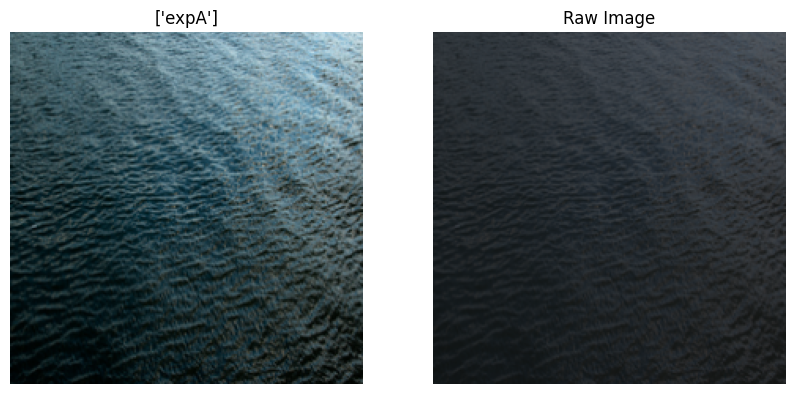

In [ ]:
# Get a batch of training data
inputs, labels = next(iter(train_dataloader))
out = inputs[:1].squeeze()

imshow(out, title=[class_directories[x] for x in labels[:1]])

In [ ]:
print(len(train_dataset))

20000


In [ ]:
class ConvBlock(torch.nn.Module):
    def __init__(self, inchannels, outchannels, downscale=False, upscale=False):
        super(ConvBlock, self).__init__()
        self.down = torch.nn.MaxPool2d(2) if downscale else torch.nn.Identity()
        self.conv1 = torch.nn.Conv2d(inchannels, outchannels, 3, padding=1)
        self.bnorm1 = torch.nn.BatchNorm2d(outchannels)
        self.conv2 = torch.nn.Conv2d(outchannels, outchannels, 3, padding=1)
        self.bnorm2 = torch.nn.BatchNorm2d(outchannels)
        self.up = torch.nn.Upsample(scale_factor=2) if upscale else torch.nn.Identity()

    def forward(self, x):
        x = self.down(x)
        x = torch.nn.functional.relu(self.bnorm1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bnorm2(self.conv2(x)))
        x = self.up(x)
        return x

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, classes, depth):
        super(UNet, self).__init__()
        self.encoder = torch.nn.ModuleList()
        channels = [3] + [64 * (2 ** i) for i in range(depth)]
        for i in range(depth):
            self.encoder.append(ConvBlock(channels[i], channels[i + 1], downscale=(i > 0)))

        self.embedding_layer = torch.nn.Embedding(classes, channels[-1])

        self.bottleneck = ConvBlock(channels[-1], channels[-1], downscale=True, upscale=True)
        self.decoder = torch.nn.ModuleList()
        channels[0] = 64
        for i in range(depth - 1, -1, -1):
            self.decoder.append(ConvBlock(2 * channels[i + 1], channels[i], upscale=(i > 0)))

        self.output = torch.nn.Sequential(
            torch.nn.Conv2d(channels[0], 3, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x, label):
        skip = []
        for mod in self.encoder:
            x = mod(x)
            skip.append(x)
        embedded_label = self.embedding_layer(label).unsqueeze(-1).unsqueeze(-1)
        embedded_label = embedded_label.expand(-1, -1, x.shape[2], x.shape[3])
        x = x + embedded_label
        x = self.bottleneck(x)
        for mod in self.decoder:
            y = skip.pop()
            x = torch.cat([x, y], 1)
            x = mod(x)
        x = self.output(x)
        return x

In [ ]:
depth = config['unetmodel']['depth']
net = UNet(classes=5, depth=3)
net = net.to(device)

In [ ]:
criterian = torch.nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

milestones = [30, 50, 70, 85]
# Decay LR by a factor of 0.1
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer):
    running_loss = 0.0
    for inputs, lables in train_dataloader:
        raw = inputs[:, :3]
        gt = inputs[:, 3:]
        raw = raw.to(device)
        gt = gt.to(device)
        lables = lables.to(device)

        optimizer.zero_grad()
        outputs = model(raw, lables)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    return epoch_loss

In [ ]:
def validate_model(model, criterion, optimizer):
    running_loss = 0.0
    with torch.no_grad():
        for inputs, lables in val_dataloader:
            raw = inputs[:, :3]
            gt = inputs[:, 3:]
            raw = raw.to(device)
            gt = gt.to(device)
            lables = lables.to(device)
            outputs = model(raw, lables)
            loss = criterion(outputs, gt)
            running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    return epoch_loss

In [ ]:
loss_type = config['unetmodel']['loss']
base_checkpoint_path = f"{config['paths']['unetcheckpoints']}_{loss_type}_{depth}"
# Create the directory if it does not exist
if not os.path.exists(base_checkpoint_path):
    os.makedirs(base_checkpoint_path)


In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
# load the last model saved if there is any
def load_latest_model(model, optimizer, scheduler, checkpoint_dir):
    # Check if the directory exists
    if not os.path.exists(base_checkpoint_path):
        print(f"No directory found: {checkpoint_dir}")
        return model, optimizer, scheduler, 0

    # Get a list of all checkpoint files in the directory
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, f'unet_*.pth'))
    # Check if any checkpoint files are present
    if not checkpoint_files:
        print(f"No checkpoints found in the directory: {checkpoint_dir}")
        return model, optimizer, scheduler, 0

    # Find the latest checkpoint file based on the epoch number in the filename
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

    # Load the latest checkpoint
    checkpoint = torch.load(latest_checkpoint, map_location=torch.device(device))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    epoch = checkpoint['epoch']

    print(f"Loaded model from checkpoint: {latest_checkpoint}")
    print(f"Resuming training from epoch {epoch}")

    return model, optimizer, scheduler, epoch


In [ ]:
net, optimizer, scheduler, current_epoch = load_latest_model(net, optimizer, scheduler, base_checkpoint_path)

No checkpoints found in the directory: /content/drive/MyDrive/thesis/model/checkpoints/unet_mae_3


In [ ]:
print(get_lr(optimizer))

0.01


In [ ]:
best_loss = 0.0
since = time.time()
num_epochs = config['unetmodel']['num_epochs']
for epoch in range(current_epoch, num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    net.train()
    training_loss = train_model(net, criterian, optimizer)
    scheduler.step()
    print(f"Training Loss: {training_loss} LR: {get_lr(optimizer):.8f}")
    net.eval()
    val_loss = validate_model(net, criterian, optimizer)
    print(f"Validation Loss: {val_loss}")
    print()

    PATH = os.path.join(base_checkpoint_path, f'unet_{epoch+1}.pth')
    state = {
            'epoch': epoch + 1,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_loss': training_loss,
            'scheduler': scheduler.state_dict(),
            'val_loss': val_loss
        }
    torch.save(state, PATH)

time_elapsed = time.time() - since
print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 1/40
----------
Training Loss: 0.09942057457566261 LR: 0.01000000
Validation Loss: 0.0240325887799263

Epoch 2/40
----------
Training Loss: 0.09287108615636826 LR: 0.01000000
Validation Loss: 0.022197514817118645

Epoch 3/40
----------
Training Loss: 0.0900381457746029 LR: 0.01000000
Validation Loss: 0.022055192410945893

Epoch 4/40
----------
Training Loss: 0.08807261243760586 LR: 0.01000000
Validation Loss: 0.020893650674819946

Epoch 5/40
----------
Training Loss: 0.08693865568637849 LR: 0.01000000
Validation Loss: 0.020751809880137445

Epoch 6/40
----------
Training Loss: 0.0860385297447443 LR: 0.01000000
Validation Loss: 0.02036037515103817

Epoch 7/40
----------
Training Loss: 0.08508203670978547 LR: 0.01000000
Validation Loss: 0.020207828584313393

Epoch 8/40
----------
Training Loss: 0.08405823517441749 LR: 0.01000000
Validation Loss: 0.019986550876498223

Epoch 9/40
----------
Training Loss: 0.08378840489983559 LR: 0.01000000
Validation Loss: 0.020010153529047964

Epoch 

In [ ]:
time.sleep(5)  # Sleep for 5 seconds to let the system cool down
from google.colab import runtime
runtime.unassign()